In [1]:
import os
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from collections import deque

In [17]:
from IPython.display import HTML
from base64 import b64encode

def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [9]:
non_violence = 'data/Real Life Violence Dataset/NonViolence'
violence = 'data/Real Life Violence Dataset/Violence'

NonViolence_files_names_list = os.listdir(non_violence)
Violence_files_names_list = os.listdir(violence)

Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [10]:
Play_Video(non_violence + '/' + Random_NonViolence_Video)

In [11]:
Play_Video(violence + '/' + Random_Violence_Video)

In [18]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
data_dir = 'data/Real Life Violence Dataset/'
classes = ['NonViolence', 'Violence']

In [13]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path) 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

In [14]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(classes):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(data_dir, class_name))
        for file_name in files_list:
            
            video_file_path = os.path.join(data_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [38]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [39]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [4]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [5]:
one_hot_encoded_labels = to_categorical(labels)

In [6]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1, shuffle = True, random_state = 42)

In [18]:
print(features_train.shape, labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [19]:
labels_train[0]

array([0., 1.], dtype=float32)

In [20]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights="imagenet")

mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

In [21]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

In [22]:
def create_model():
 
    model = Sequential()

    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))    

    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))
    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(classes), activation = 'softmax'))
  
    model.summary()
    
    return model

In [23]:
mobile_BILSTM_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [28]:
# Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate when the model stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005,
verbose=1)

In [29]:
mobile_BILSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

In [30]:
MobBiLSTM_model_history = mobile_BILSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback, reduce_lr])

Epoch 1/50


180/180 [==============================] - 106s 529ms/step - loss: 0.6962 - accuracy: 0.5097 - val_loss: 0.6916 - val_accuracy: 0.5139 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 98s 547ms/step - loss: 0.6901 - accuracy: 0.5146 - val_loss: 0.6861 - val_accuracy: 0.5222 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 96s 536ms/step - loss: 0.6820 - accuracy: 0.5576 - val_loss: 0.6529 - val_accuracy: 0.7056 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 100s 553ms/step - loss: 0.6037 - accuracy: 0.6792 - val_loss: 0.4987 - val_accuracy: 0.7722 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 88s 491ms/step - loss: 0.4692 - accuracy: 0.8056 - val_loss: 0.5282 - val_accuracy: 0.7694 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 85s 472ms/step - loss: 0.3776 - accuracy: 0.8493 - val_loss: 0.9163 - val_accuracy: 0.6639 - lr: 0.0100
Epoch 7/50
180/180 [============================

In [32]:
model_test_eval = mobile_BILSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 5s 380ms/step - loss: 0.1964 - accuracy: 0.9400


In [33]:
mobile_BILSTM_model.save("mobile_BILSTM_model.h5")

c:\Users\esaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
model = keras.models.load_model("mobile_BILSTM_model.h5")

In [12]:
labels_predict = model.predict(features_test)

7/7 [==============================] - 4s 561ms/step


In [13]:
labels_test_normal = np.argmax(labels_test , axis=1)

In [14]:
labels_predict.shape

(200, 2)

In [19]:
report = classification_report(labels_test_normal, np.argmax(labels_predict, axis=1), target_names=classes)
print(report)

              precision    recall  f1-score   support

 NonViolence       0.96      0.92      0.94        99
    Violence       0.92      0.96      0.94       101

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



In [51]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    predicted_class_name = ''
 
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
 
        frames_queue.append(normalized_frame)
 
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            predicted_class_name = classes[predicted_label]
 
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [65]:
plt.style.use("default")

def show_pred_frames(pred_video_path): 
    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        ax = plt.gca()  # Access the current Axes object
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read() 

        if not ok:
          break 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [66]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 75ms/step


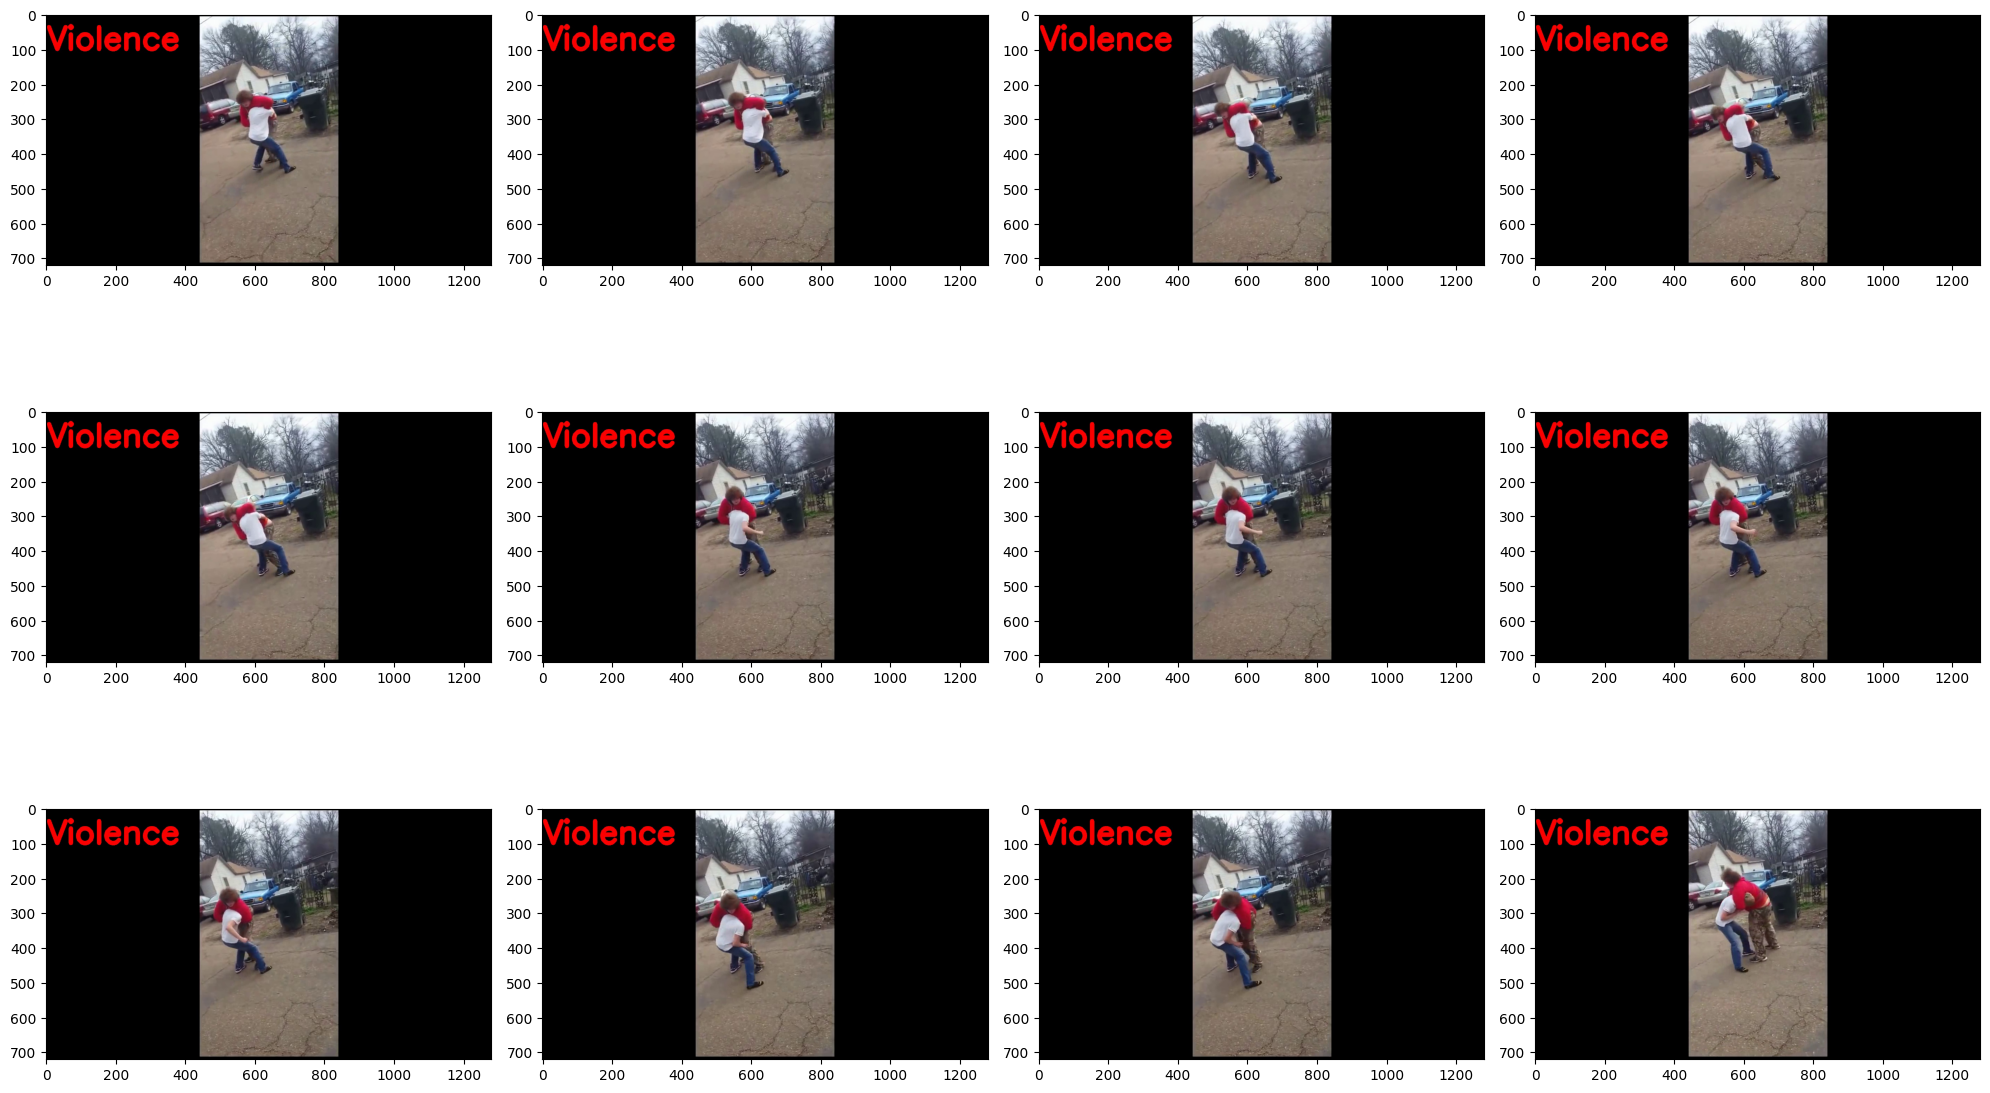

In [73]:
input_video_file_path = 'data/Real Life Violence Dataset/Violence/V_121.mp4'
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
show_pred_frames(output_video_file_path)

In [68]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    frames_list = []
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = classes[predicted_label]
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [74]:
predict_video(input_video_file_path, 4)

1/1 [==============================] - 0s 48ms/step
Predicted: Violence
Confidence: 0.9872176051139832
